In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

import glob, os
import my_lib as ml

import seaborn as sns
sns.set_style("darkgrid")

from IPython.display import display, Markdown
pd.set_option('display.max_columns', None)  

SEED = 42
target = "TARGET"
feature_labels = {}

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
df = pd.read_csv(f"data/df_train_sample_00_of_20.csv", dtype=str)
display(df.head(2))
display(df.shape)

,RECORD_ID,DISCHARGE,THCIC_ID,PROVIDER_NAME,TYPE_OF_ADMISSION,SOURCE_OF_ADMISSION,PAT_STATE,PAT_COUNTRY,COUNTY,PUBLIC_HEALTH_REGION,PAT_STATUS,SEX_CODE,RACE,ETHNICITY,ADMIT_WEEKDAY,LENGTH_OF_STAY,PAT_AGE,FIRST_PAYMENT_SRC,TYPE_OF_BILL,TOTAL_CHARGES,TOTAL_NON_COV_CHARGES,TOTAL_CHARGES_ACCOMM,TOTAL_NON_COV_CHARGES_ACCOMM,TOTAL_CHARGES_ANCIL,TOTAL_NON_COV_CHARGES_ANCIL,POA_PROVIDER_INDICATOR,ADMITTING_DIAGNOSIS,PRINC_DIAG_CODE,OTH_DIAG_CODE_1,MS_MDC,MS_DRG,MS_GROUPER_VERSION_NBR,MS_GROUPER_ERROR_CODE,APR_MDC,APR_DRG,RISK_MORTALITY,ILLNESS_SEVERITY,APR_GROUPER_VERSION_NBR,APR_GROUPER_ERROR_CODE,ATTENDING_PHYSICIAN_UNIF_ID,ENCOUNTER_INDICATOR,CERT_STATUS,TARGET
0,320136748870,2013Q3,838400,Memorial Hermann Rehab Hospital Katy,3,4,TX,US,201,06,07,F,4,2,2,1,20,MA,111,1671.00,0.00,1145.00,0.00,526.00,0.00,X,V5789,V5789,1919,23,945,01300,00,23,860,2,3,07300,00,1229763162,01,1,short
1,120130546450,2013Q1,409000,John Peter Smith Hospital,1,1,TX,US,367,03,01,M,5,1,2,2,13,MA,111,53064.01,0.00,4092.00,0.00,48972.01,0.00,M,78650,41401,42822,05,247,01300,00,05,175,2,2,07300,00,1578252829,01,2,short


(49984, 43)

## Convert Target Categrories into codes or numbers

In [4]:
from sklearn.preprocessing import LabelEncoder

if df.TARGET.dtype != int:
    print("Encoding Taget....")
    lb = LabelEncoder()
    df["TARGET"] = lb.fit_transform(df.TARGET)
    print("DONE")
else:
    print("Encoding already performed.")
    pass

Encoding Taget....
DONE


## Cleaning of Categorical Features
- mergin rare categories

In [5]:
# TYPES_OF_ADMISSION

feature = "TYPE_OF_ADMISSION"
print(f'Before Cleaning {df[feature].unique()}')
df[feature].fillna("9", inplace=True)
df.loc[df[feature].isin(["`"]), feature] = "9"
print(f'After Cleaning {df[feature].unique()}')

codes = df["TYPE_OF_ADMISSION"].unique()
labels = ["Emergency", "Urgent", "Elective", "Newborn", "Trauma Center", "Information Not Available"]
feature_labels["TYPE_OF_ADMISSION"] = {c:"(%s) %s" %(c,l) for c,l in zip(codes,labels)}

Before Cleaning ['3' '1' '2' '4' '5' '9' '`']
After Cleaning ['3' '1' '2' '4' '5' '9']


In [6]:
# SOURCE_OF_ADMISSION

feature = "SOURCE_OF_ADMISSION"
print(f'Before Cleaning {df[feature].unique()}')
df[feature].fillna("9", inplace=True)
df.loc[df[feature].isin(["`", "3", "NaN", "7"]), feature] = "9"
print(f'After Cleaning {df[feature].unique()}')

encode_labels = lambda s: {line[0]: "(%s) %s" % (line[0], line[2:].strip()) for line in s.split("\n") if len(line) > 0}

feature_labels["SOURCE_OF_ADMISSION"] = encode_labels("""
1 Non-Healthcare Facility Point of Origin
2 Clinic referral
4 Transfer from a hospital
5 Transfer from a skilled nursing facility
6 Transfer from another health care facility
8 Court/Law Enforcement
9 Information not available
0 Transfer from psychiatric hospital
B Transfer from another home health agency
D Transfer within Hospital
E Transfer from Amubulatory Surgery Center
F Transfer from a Hospice Facility
` Invalid """)

Before Cleaning ['4' '1' '2' '8' '5' '9' '6' '`' 'D' nan '3']
After Cleaning ['4' '1' '2' '8' '5' '9' '6' 'D']


In [7]:
# PAT_STATE

feature = "PAT_STATE"
print(f'Before Cleaning {df[feature].unique()}')
df[feature].fillna("XX", inplace=True)
df.loc[df[feature].isin(["FC","`"]), feature] = "XX"
df.loc[df[feature].isin(["NM","AR","OK", "LA"]), feature] = "XX"
print(f'After Cleaning {df[feature].unique()}')

codes = df["PAT_STATE"].unique()
labels = ["Texas", "Foreign country", "All other states and American Territories"]
feature_labels["PAT_STATE"] = {c:"(%s) %s" %(c,l) for c,l in zip(codes,labels)}

Before Cleaning ['TX' 'NM' 'FC' 'AR' 'ZZ' 'LA' 'OK' 'XX' nan '`']
After Cleaning ['TX' 'XX' 'ZZ']


In [8]:
# SEX_CODE

feature = "SEX_CODE"
print(f'Before Cleaning {df[feature].unique()}')
df[feature].fillna("U", inplace=True)
df.loc[df[feature].isin(["nan","`"]), feature] = "U"
print(f'After Cleaning {df[feature].unique()}')

codes = df["SEX_CODE"].unique()
labels = ["Female", "Male", "Unknown"]
feature_labels["SEX_CODE"] = {c:"(%s) %s" %(c,l) for c,l in zip(codes,labels)}

Before Cleaning ['F' 'M' nan 'U']
After Cleaning ['F' 'M' 'U']


In [9]:
# RACE

feature = "RACE"
print(f'Before Cleaning {df[feature].unique()}')
df[feature].fillna("5", inplace=True)
df.loc[df[feature].isin(["nan", "`"]), feature] = "5"
print(f'After Cleaning {df[feature].unique()}')

codes = df["RACE"].unique()
labels = ["White", "Other", "Black", "Asian or Pacific Islander", "American Indian/Eskimo/Aleut"]
feature_labels["RACE"] = {c:"(%s) %s" %(c,l) for c,l in zip(codes,labels)}

Before Cleaning ['4' '5' '3' '2' '1' nan '`']
After Cleaning ['4' '5' '3' '2' '1']


In [10]:
# ETHNICITY

feature = "ETHNICITY"
print(f'Before Cleaning {df[feature].unique()}')
df[feature].fillna("3", inplace=True)
df.loc[df[feature].isin(["nan", "`"]), feature] = "3"
print(f'After Cleaning {df[feature].unique()}')

codes = df["ETHNICITY"].unique()
labels = ["Not of Hispanic Origin", "Hispanic Origin", "Unknown"]
feature_labels["ETHNICITY"] = {c:"(%s) %s" %(c,l) for c,l in zip(codes,labels)}

Before Cleaning ['2' '1' nan '`']
After Cleaning ['2' '1' '3']


In [11]:
# ADMIT_WEEKDAY

encode_labels = lambda s: {line[0]: "(%s) %s" % (line[0], line[2:].strip()) for line in s.split("\n") if len(line) > 0}

feature_labels["ADMIT_WEEKDAY"] = encode_labels("""
1 Monday 
2 Tuesday 
3 Wednesday 
4 Thursday 
5 Friday
6 Saturday
7 Sunday
` Invalid""")

#### SOURCE_OF_ADMISSION

**Distribution**

(1) Non-Healthcare Facility Point of Origin       29906
(2) Clinic referral                                8779
(5) Transfer from a skilled nursing facility       6636
(4) Transfer from a hospital                       3304
(6) Transfer from another health care facility      427
(8) Court/Law Enforcement                           408
(9) Information not available                       274
(D) Transfer within Hospital                        250
Name: SOURCE_OF_ADMISSION, dtype: int64

**Count Plots**

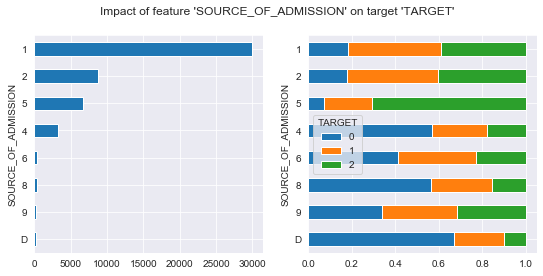

TARGET,0,1,2
SOURCE_OF_ADMISSION,,,
1,5458,12748,11700
2,1559,3683,3537
4,1882,834,588
5,473,1483,4680
6,176,154,97
8,230,114,64
9,93,95,86
D,168,57,25


**Chi-Sq Goodness of Fit**

Chi-Square statistic 6.3261e+03 (p=0.0000e+00, dof=14)




#### PAT_STATE

**Distribution**

(TX) Texas                                        48606
(XX) Foreign country                                966
(ZZ) All other states and American Territories      412
Name: PAT_STATE, dtype: int64

**Count Plots**

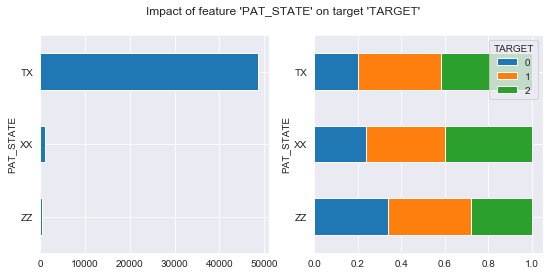

TARGET,0,1,2
PAT_STATE,,,
TX,9670,18661,20275
XX,229,351,386
ZZ,140,156,116


**Chi-Sq Goodness of Fit**

Chi-Square statistic 6.6541e+01 (p=1.2183e-13, dof=4)




#### SEX_CODE

**Distribution**

(F) Female     27809
(M) Male       18638
(U) Unknown     3537
Name: SEX_CODE, dtype: int64

**Count Plots**

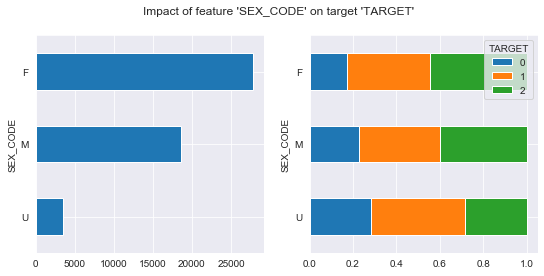

TARGET,0,1,2
SEX_CODE,,,
F,4776,10682,12351
M,4262,6952,7424
U,1001,1534,1002


**Chi-Sq Goodness of Fit**

Chi-Square statistic 5.5346e+02 (p=1.8264e-118, dof=4)




#### RACE

**Distribution**

(4) White                           31220
(5) Other                           11020
(3) Black                            6585
(2) Asian or Pacific Islander        1021
(1) American Indian/Eskimo/Aleut      138
Name: RACE, dtype: int64

**Count Plots**

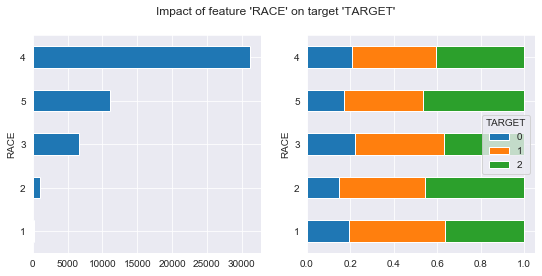

TARGET,0,1,2
RACE,,,
1,27,61,50
2,153,401,467
3,1464,2691,2430
4,6496,12016,12708
5,1899,3999,5122


**Chi-Sq Goodness of Fit**

Chi-Square statistic 2.1506e+02 (p=4.2563e-42, dof=8)




#### ETHNICITY

**Distribution**

(2) Not of Hispanic Origin    35094
(1) Hispanic Origin           14334
(3) Unknown                     556
Name: ETHNICITY, dtype: int64

**Count Plots**

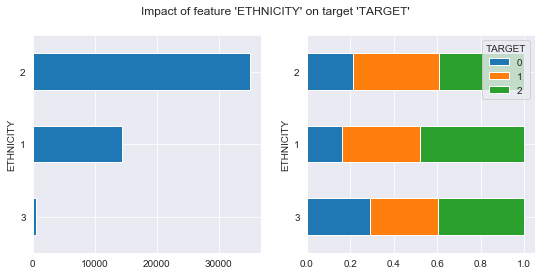

TARGET,0,1,2
ETHNICITY,,,
1,2354,5132,6848
2,7523,13863,13708
3,162,173,221


**Chi-Sq Goodness of Fit**

Chi-Square statistic 3.8068e+02 (p=4.1462e-81, dof=4)




#### ADMIT_WEEKDAY

**Distribution**

(1) Monday       8746
(2) Tuesday      8555
(3) Wednesday    8078
(4) Thursday     7792
(5) Friday       7411
(6) Saturday     4815
(7) Sunday       4587
Name: ADMIT_WEEKDAY, dtype: int64

**Count Plots**

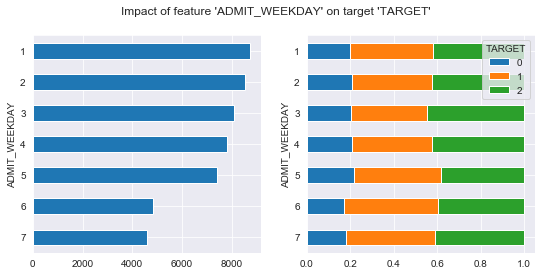

TARGET,0,1,2
ADMIT_WEEKDAY,,,
1,1742,3337,3667
2,1791,3154,3610
3,1650,2832,3596
4,1610,2887,3295
5,1601,2990,2820
6,816,2089,1910
7,829,1879,1879


**Chi-Sq Goodness of Fit**

Chi-Square statistic 1.7084e+02 (p=3.2118e-30, dof=12)


In [12]:
target_features = [ "SOURCE_OF_ADMISSION", "PAT_STATE", "SEX_CODE", "RACE", "ETHNICITY", "ADMIT_WEEKDAY"] #"PAT_AGE"]

for tf in target_features:
    ml.eda_categorical(df, tf, target, max_categories=20, labels=feature_labels[tf], header=True, brief=False)